In [1]:
import sys
import os
# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [2]:
# Loading Config
from utils.config import load_yaml_config, merge_configs, dict_to_namespace
import numpy as np

default_yaml = "../utils/configs/default.yaml"
problem_yaml = "../utils/configs/ramon_problem_5.yaml"
category_yaml = "../utils/configs/experiment_tn.yaml"

custom_config_files = [default_yaml, problem_yaml, category_yaml] # Add more config files if needed
configs = [load_yaml_config(config_file) for config_file in custom_config_files]
yaml = merge_configs(*configs)

## Here you can modify the yaml object to change the configuration
## Example: yaml.seed = 123, yaml.max_num_tasks = 10
config = dict_to_namespace(yaml)

In [3]:
import torch
import random

# Set random seeds for reproducibility

random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)

In [4]:
config.invalid_action_replacement = True

In [5]:
config.train = False
config.evaluate = True

In [6]:
from env.cades_env import CadesEnv
from stable_baselines3.common.env_checker import check_env

# Initialize and check the environment
env = CadesEnv(config)
check_env(env)

/home/ediss5/anaconda3/envs/cades/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:190: UserWarning: Your observation communications has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [7]:
from models.ppo import PPOModel

model = PPOModel.load("../mlruns/802427248900867940/f9b407a202b84f53be918f8c487d9c32/artifacts/models/best_model", env, config)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
from env.extended_states_generator import ExtendedStatesGenerator
import copy

def change_states(env, num_tasks):
    
    new_config = copy.deepcopy(config)
    new_config.max_num_tasks = num_tasks
    new_config.min_num_tasks = num_tasks
    old_generator = env.states_generator
    env.states_generator = ExtendedStatesGenerator(new_config)
    # Use the new state generator to generate the states
    states = env.generate_states(training=False)

    if(env.config.max_num_tasks != env.states_generator.max_num_tasks): # If the state generator did not generate the maximum number of tasks
        ## Pad the states to the maximum number of tasks
        indices_to_pad = env.config.max_num_tasks - env.states_generator.max_num_tasks
        padded_tasks = np.pad(states['tasks'], (0, indices_to_pad), mode='constant')
        padded_critical_mask = np.pad(states['critical_mask'], (0, indices_to_pad), mode='constant')
        padded_communications = np.pad(states['communications'], ((0, indices_to_pad), (0, indices_to_pad)), mode='constant')
        states['tasks'] = padded_tasks
        states['critical_mask'] = padded_critical_mask
        states['communications'] = padded_communications
    
    # Restore the old state generator
    env.states_generator = old_generator
    return states

In [9]:
import pandas as pd
time_taken = pd.DataFrame(columns=['ppo', 'ffd'])

In [10]:
values = []
for num_tasks in range(1, env.config.max_num_tasks + 1):
    states = change_states(env, num_tasks)
    result = model.evaluate(states=states)
    inference_time = round(result['inference_time'] * 1000, 2) # Convert to milliseconds
    values.append(inference_time)
    
time_taken['ppo'] = values

In [11]:
# redefine model's predict method to use the heuristic
from heuristics.ffd import FirstFitDecreasingHeuristic
heuristic = FirstFitDecreasingHeuristic(env)
model.model.predict = heuristic.predict

In [12]:
values = []
for num_tasks in range(1, env.config.max_num_tasks + 1):
    states = change_states(env, num_tasks)
    heuristic.set_state(states)
    result = model.evaluate(states=states)
    inference_time = round(result['inference_time'] * 1000, 2) # Convert to milliseconds
    values.append(inference_time)
    
time_taken['ffd'] = values

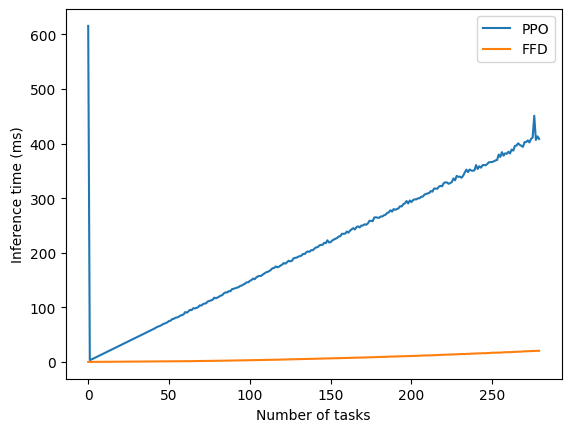

In [13]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(time_taken['ppo'], label='PPO')
plt.plot(time_taken['ffd'], label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Inference time (ms)')
plt.legend()
plt.show()